Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

Get Data Set and Display it

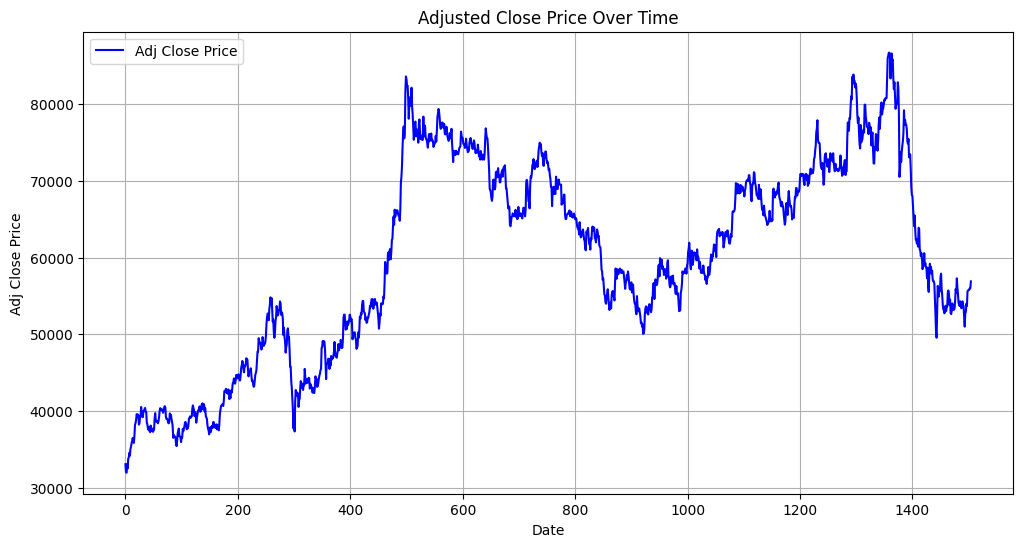

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1505 entries, 0 to 1504
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1505 non-null   object 
 1   Open       1505 non-null   float64
 2   High       1505 non-null   float64
 3   Low        1505 non-null   float64
 4   Close      1505 non-null   float64
 5   Adj Close  1505 non-null   float64
 6   Volume     1505 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 82.4+ KB


In [2]:
data = pd.read_csv("Data/005930.KS.csv")

df = data.copy()

# 3. Plotting the Price Data (using Adj Close as the primary example)
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.plot(df['Adj Close'], label='Adj Close Price', color='blue')
plt.title('Adjusted Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.grid(True)
plt.legend()
plt.show()

df.dropna(inplace=True)

df.info()

Processing

In [3]:
# Split original dataset into training and test sets while preserving original scale
train_size = int(0.8 * len(data))
train_data_original = df[:train_size]
test_data_original = df[train_size:]

# Scale features and target using MinMaxScaler
scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(data[['Open', 'High', 'Low', 'Volume']])

features = df[['Open', 'High', 'Low', 'Volume']]  # Define input features


scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(data[['Adj Close']])
print("NaN in target_scaled:", np.isnan(target_scaled).sum())  # Check scaled values

# Split scaled data into train and test sets
X_train = features_scaled[:train_size]
X_test = features_scaled[train_size:]
y_train = target_scaled[:train_size]
y_test = target_scaled[train_size:]

NaN in target_scaled: 0


Build Nueral Network

In [4]:
model = Sequential()
model.add(Dense(128, input_dim=features.shape[1], activation='relu'))  # Input layer
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='linear'))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

c:\Users\ruanl\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Model

In [5]:
model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0255 - mae: 0.0948 - val_loss: 0.0059 - val_mae: 0.0740
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9331e-04 - mae: 0.0227 - val_loss: 0.0054 - val_mae: 0.0680
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0173e-04 - mae: 0.0229 - val_loss: 0.0048 - val_mae: 0.0644
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9197e-04 - mae: 0.0222 - val_loss: 0.0060 - val_mae: 0.0738
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3321e-04 - mae: 0.0212 - val_loss: 0.0058 - val_mae: 0.0718
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4166e-04 - mae: 0.0210 - val_loss: 0.0053 - val_mae: 0.0680
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9308e-04 - mae: 0.0209 - val_loss: 0.0098 - val_mae: 0.0954
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1272e-04 - mae: 0.0222 - val_loss: 0.0045 - val_mae: 0.0625
Epoch 9/50
151/151 ━━━━━━━━━

Predict

In [6]:
y_pred = model.predict(X_test)
# 4. Make predictions
predictions_scaled = model.predict(X_test)
predictions_original = scaler_target.inverse_transform(predictions_scaled)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [7]:
num_future_steps = 30  # Number of days to predict into the future
future_predictions_scaled = []
future_predictions_original = []

# Use the last training data and the test predictions to start the iterative process
last_known_features_scaled = X_test[-1:].copy() # shape (1, 4)

for _ in range(num_future_steps):
    # Predict the next step
    next_prediction_scaled = model.predict(last_known_features_scaled)
    next_prediction_original = scaler_target.inverse_transform(next_prediction_scaled)

    # Store the prediction
    future_predictions_scaled.append(next_prediction_scaled[0][0])
    future_predictions_original.append(next_prediction_original[0][0])

    # Update last_known_features_scaled for the next iteration
    #  Important:  You need to create a new input feature set for the next prediction.
    #  In this example, I'm using a simple approach:
    #  1.  Shift the existing features (Open, High, Low, Volume) one step forward
    #  2.  Use the predicted 'Adj Close' as part of the new input
    #  This is a simplification and you might need a more sophisticated way
    #  to estimate future 'Open', 'High', 'Low', and 'Volume'
    new_features_scaled = last_known_features_scaled.copy()
    new_features_scaled[0, 0] = new_features_scaled[0, 1] # Open = High
    new_features_scaled[0, 1] = new_features_scaled[0, 2] # High = Low
    new_features_scaled[0, 2] = next_prediction_scaled[0][0] # Low = Predicted Adj Close
    # For Volume, you might use the last known volume, an average, or a predicted volume.
    #  Here, I'm using the last known volume as a placeholder.  THIS IS A SIMPLIFICATION.
    new_features_scaled[0, 3] = new_features_scaled[0, 3]
    last_known_features_scaled = new_features_scaled



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

Evaluate the model

In [8]:
def calculate_accuracy(y_true, y_pred):
    """
    Calculates the accuracy based on Mean Absolute Percentage Error (MAPE).

    Args:
        y_true (array-like): Array of actual (true) values.
        y_pred (array-like): Array of predicted values.

    Returns:
        float: Accuracy (percentage).  Returns 0 if y_true has any zero values.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Handle cases with zero values in y_true to avoid division by zero
    if np.any(y_true == 0):
        print("Warning: Actual values contain zeros. MAPE and accuracy are undefined.")
        return 0.0  # Or you might want to raise an exception:  raise ValueError("Actual values cannot be zero.")

    # Calculate absolute percentage errors
    absolute_percentage_errors = np.abs((y_true - y_pred) / y_true) * 100

    # Calculate MAPE
    mape = np.mean(absolute_percentage_errors)

    # Calculate accuracy
    accuracy = 100 - mape

    return accuracy

In [9]:

print(f'Accuracy: {calculate_accuracy(y_test,y_pred):.2f}%')


Accuracy: 86.95%


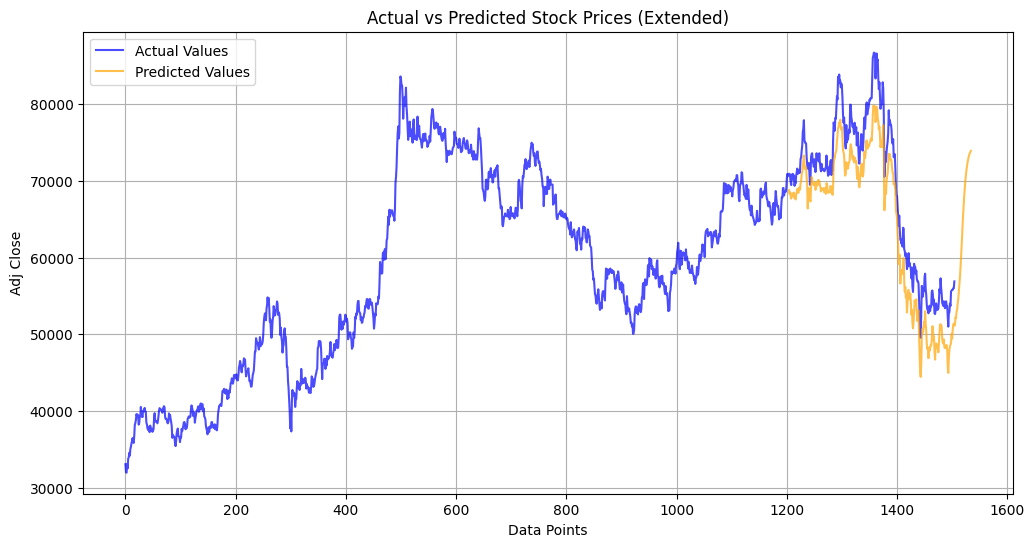

In [ ]:
all_predictions_original = np.concatenate([predictions_original.flatten(), future_predictions_original])
all_actual_original = df['Adj Close'].values  # Use the original 'Adj Close'

plt.figure(figsize=(12, 6))
plt.plot(all_actual_original, label="Actual Values", color="blue", alpha=0.7)
plt.plot(range(train_size, train_size + len(all_predictions_original)), all_predictions_original, label="Predicted Values", color="orange", alpha=0.7)
plt.xlabel("Data Points")
plt.ylabel("Adj Close")
plt.title("Actual vs Predicted Stock Prices (Extended)")
plt.legend()
plt.grid(True)
plt.show()